In [2]:
from utils.libraries import *
from utils.objects import *
from utils.functions import *
from definitions import *
from Economic_Market_Forecasting_ML_V2 import *

In [3]:
target = "SPY"
df = pd.read_csv(r"C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\src\data\raw\market_df.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df = df.pct_change().dropna().cumsum()

### Market Momentum

In [ ]:
df_125MA = df[[target]].rolling(window=125).mean().fillna(method="ffill").fillna(method="bfill")
df_target = pd.concat([df[[target]], df_125MA, df[["GDX"]]], axis=1)
df_target.columns = [target, target+"_125MA", "GDX"]
# df_target[target+"_pct_change"] = df_target[target].pct_change()
df_target[target+"_125MA_Spread"] = (df_target[target] - df_target[target+"_125MA"])
df_target[target+"_Spread_125MA"] = df_target[target+"_125MA_Spread"].rolling(window=125).mean().fillna(method="ffill").fillna(method="bfill")
# df_target[target+"_Spread_125MA_Spread"] = (df_target[target+"_125MA_Spread"] - df_target[target+"_Spread_125MA"])


std = df_target[target+"_125MA_Spread"].std()
lst_greed = []
lst_fear = []
for i in range(0,175, 25):
    print(i)
    df_target["Greed_"+str(i)] = (df_target[target+"_125MA_Spread"]>((i/100)*std)).astype(int)
    lst_greed.append("Greed_"+str(i))
    df_target["Fear_"+str(i)] = -((df_target[target+"_125MA_Spread"]<((i/100)*-std)).astype(int))
    lst_fear.append("Fear_"+str(i))
df_target["Greed"] = df_target[lst_greed].sum(axis=1)/len(lst_greed)
df_target["Fear"] = df_target[lst_fear].sum(axis=1)/len(lst_fear)


fig, ax1 = plt.subplots(figsize=(10, 5), sharex=True)
fig.add_gridspec(2,2)
t = len(df_target)
t = 252
color = ['blue', 'orange']
ax1.set_ylabel(target)
ax1.plot(df_target[["Greed","Fear"]].iloc[-t:])
ax1.tick_params(axis='y')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'orange'
ax2.set_ylabel('Spread')  # we already handled the x-label with ax1
ax2.plot(df_target[[target+"_125MA_Spread"]].iloc[-t:], color=color)
ax2.tick_params(axis='y')
ax2.axhline(y=std, color='red', linestyle='--')
ax2.axhline(y=-std, color='green', linestyle='--')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Stock Price Strength

In [180]:
def market_extraction(stocks, start, end, root_path):
    """
    Extrae datos de mercado históricos para una lista determinada de acciones entre una fecha de inicio y finalización especificada.

    Args:
    - stocks (lst): Lista de acciones para extraer datos.
    - start (str): fecha de inicio en formato yyyy-mm-dd.
    - end (str): fecha de finalización en formato yyyy-mm-dd.

    Returns:
    - market_hist (pd.DataFrame): Pandas DataFrame que contiene datos de mercado históricos para las acciones y el rango de fechas especificados.
    """
    # Permite crear el DataFrame
    yfin.pdr_override()
    # Extraer los precios de !Yahoo Finanzas para cada uno de los indices y almacenarlos en el DataFrame 'markets'
    markets = pdr.get_data_yahoo(stocks,start=start,end=end)
    # Filtrar el DataFrame quedandonos con la columna de 'Adj Close' y el rango temporal previamente definido
    market_hist = markets["Adj Close"].loc[start:end]# Guardar el DataFrame como un archivo csv
    path = root_path #.joinpath('stock_prices.csv')
    # market_hist.to_csv(path)
    return market_hist

In [284]:
from stocksymbol import StockSymbol

date=datetime.today()
timeframe = 365*2
today = date
end = today.strftime("%Y-%m-%d")
start = (today - dt.timedelta(days=timeframe)).strftime("%Y-%m-%d")
ROOT_PATH = Path(r"C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\src\data\raw\stock_prices\stock_prices.csv")

api_key = "9ee7df0a-65b9-42ca-a8a5-5b8ea2b9a562"
ss = StockSymbol(api_key)

# get symbol list based on index
symbol_list_spx = ss.get_symbol_list(index="SPX")

lst_stock = []
for stock in symbol_list_spx:
    ticker = stock['symbol']
    lst_stock.append(ticker)

In [ ]:

market_hist = market_extraction(lst_stock, start, end, ROOT_PATH)


In [344]:
lst_stock_1 = lst_stock[:30]
ROOT_PATH = Path(r"C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\src\data\raw\stock_prices\stock_prices_test.csv")
# Permite crear el DataFrame
yfin.pdr_override()
# Extraer los precios de !Yahoo Finanzas para cada uno de los indices y almacenarlos en el DataFrame 'markets'
markets = pdr.get_data_yahoo(lst_stock_1,start=start,end=end)

[*********************100%***********************]  30 of 30 completed

2 Failed downloads:
- FB: No timezone found, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted


In [349]:
market_close = markets["Adj Close"]
market_volume = markets["Volume"]

In [350]:
df_advancing_volume = market_volume[market_close - market_close.shift(1) > 0].sum(axis=1)
df_declining_volume = market_volume[market_close - market_close.shift(1) < 0].sum(axis=1)

In [351]:
df_MVSI = pd.DataFrame([df_advancing_volume, df_declining_volume], index=['Advancing', 'Declining']).T
df_MVSI['Advancing EMA'] = df_MVSI['Advancing'].ewm(span=19, adjust=False).mean()
df_MVSI['Declining EMA'] = df_MVSI['Declining'].ewm(span=39, adjust=False).mean()
df_MVSI['Oscillator'] = df_MVSI['Advancing EMA'] - df_MVSI['Declining EMA']
df_MVSI["MVSI"] = df_MVSI["Oscillator"].cumsum()

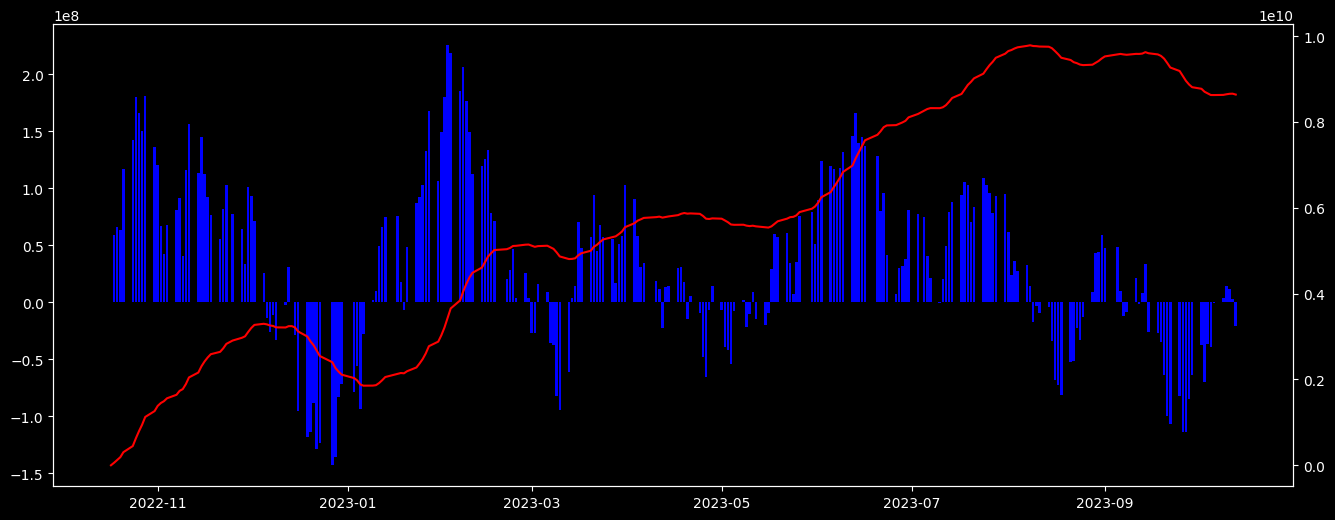

In [352]:
fig, ax1 = plt.subplots(figsize=(16, 6))
ax1.bar(df_MVSI.index, df_MVSI["Oscillator"], color="blue")
ax2 = ax1.twinx()
ax2.plot(df_MVSI.index, df_MVSI["MVSI"], color="red")

In [311]:
market_hist.to_csv(r"C:\Users\Joan Oliver\Documents\GitHub\Economic_Market_Forecasting\Economic_Market_Forecasting\EMF_webapp\src\data\raw\stock_prices\stock_prices.csv")

In [203]:
df = market_hist.copy()

(((df.max(axis=0)-df.iloc[-1])/df.iloc[-1])<.05).astype(int)
(((df.iloc[-1]-df.min(axis=0))/df.min(axis=0))<.05).astype(int)


A       1
AAL     0
AAP     1
AAPL    0
ABBV    0
       ..
YUM     0
ZBH     0
ZBRA    1
ZION    0
ZTS     0
Length: 504, dtype: int32

<AxesSubplot:xlabel='Date'>

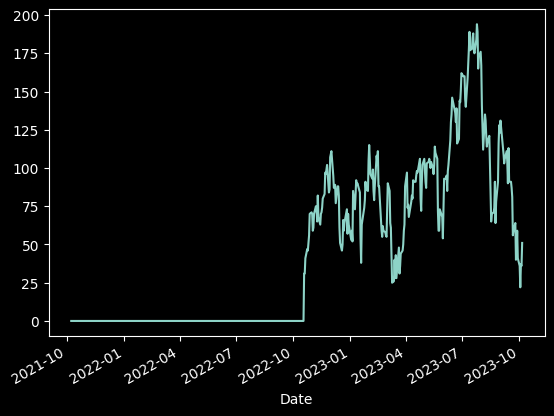

In [253]:
df_max = pd.DataFrame()
cnt = 0
for stock in df.columns:
    result = df[[stock]].rolling(window=52*5).max()
    stock_max = (((result - df[[stock]])/df[[stock]])<=.05).astype(int)
    df_max = pd.concat([df_max, stock_max], axis=1)
    cnt=+1
df_max_total = df_max.sum(axis=1)
df_max_total.plot()

<AxesSubplot:xlabel='Date'>

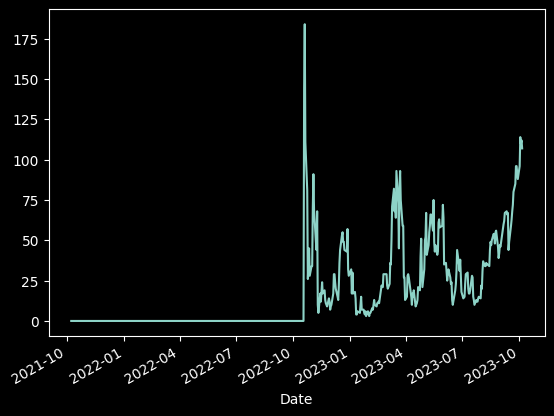

In [254]:
df_min = pd.DataFrame()
cnt = 0
for stock in df.columns:
    result = df[[stock]].rolling(window=52*5).min()
    stock_min = (((df[[stock]] - result) / result)<=.05).astype(int)
    df_min = pd.concat([df_min, stock_min], axis=1)
    cnt=+1
df_min_total = df_min.sum(axis=1)
df_min_total.plot()

In [259]:
df_strength = ((df_max_total/df_min_total)-df_min_total)/100

<AxesSubplot:xlabel='Date'>

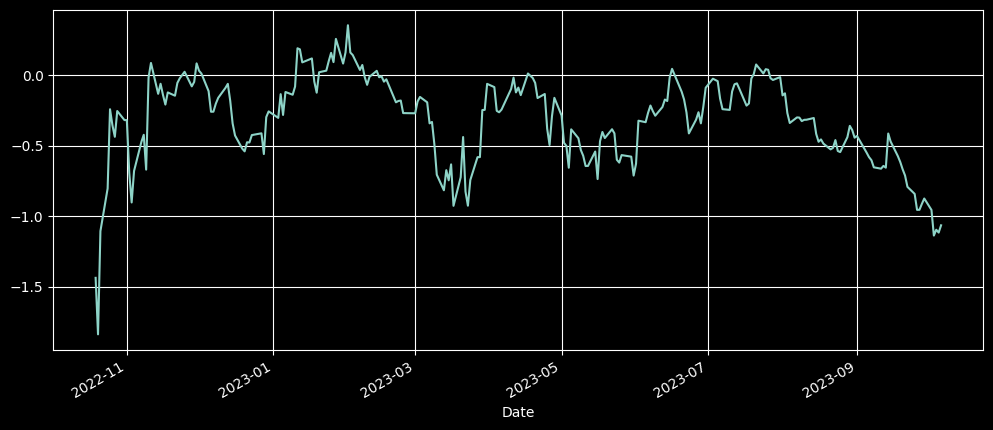

In [260]:
df_strength.plot(figsize=(12,5), grid=True)

<AxesSubplot:xlabel='Date'>

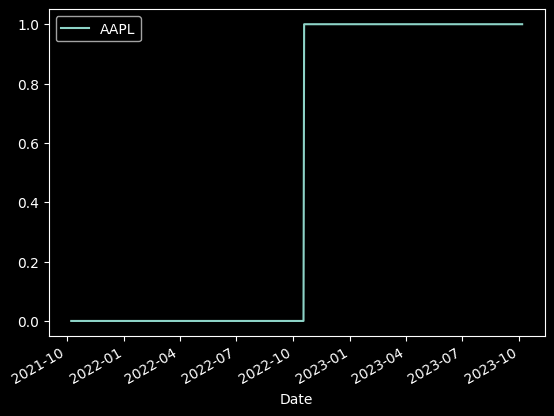

In [263]:
result = df[["AAPL"]].rolling(window=52*5).max()
(((df[["AAPL"]] - result)/result)<=.05).astype(int).plot()

<AxesSubplot:xlabel='Date'>

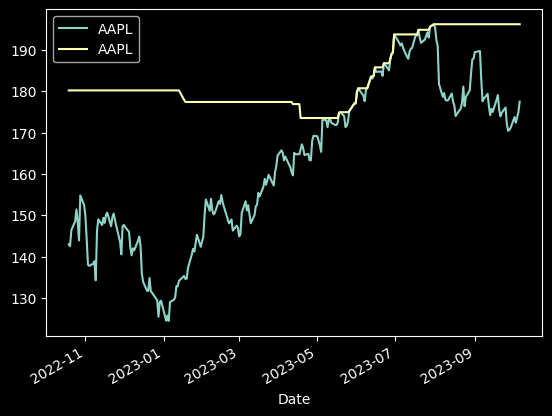

In [264]:


ax = df[["AAPL"]].loc[result.dropna().index[0]:].plot()
result.plot(ax=ax)

In [218]:
result

,AAPL
Date,
2021-10-08 00:00:00-04:00,NaN
2021-10-11 00:00:00-04:00,NaN
2021-10-12 00:00:00-04:00,NaN
2021-10-13 00:00:00-04:00,NaN
2021-10-14 00:00:00-04:00,NaN
...,...
2023-10-02 00:00:00-04:00,196.185074
2023-10-03 00:00:00-04:00,196.185074
2023-10-04 00:00:00-04:00,196.185074
